# sequence to sequence
https://blog.csdn.net/Yellow_python/article/details/87824778

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')  # 不打印警告
import numpy as np, matplotlib.pyplot as mp
%matplotlib inline
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Input, LSTM

## 配置

In [2]:
units = 200  # LSTM神经元数量
len_input = 7  # 输入序列长度（输出序列长度=16-7=9）
epochs = 1000

## 语料

In [3]:
seqs = """
《长恨歌》——白居易
汉皇重色思倾国，御宇多年求不得。
杨家有女初长成，养在深闺人未识。
天生丽质难自弃，一朝选在君王侧。
回眸一笑百媚生，六宫粉黛无颜色。
春寒赐浴华清池，温泉水滑洗凝脂。
侍儿扶起娇无力，始是新承恩泽时。
云鬓花颜金步摇，芙蓉帐暖度春宵。
春宵苦短日高起，从此君王不早朝。
承欢侍宴无闲暇，春从春游夜专夜。
后宫佳丽三千人，三千宠爱在一身。
金屋妆成娇侍夜，玉楼宴罢醉和春。
姊妹弟兄皆列土，可怜光彩生门户。
遂令天下父母心，不重生男重生女。
骊宫高处入青云，仙乐风飘处处闻。
缓歌慢舞凝丝竹，尽日君王看不足。
渔阳鼙鼓动地来，惊破霓裳羽衣曲。
九重城阙烟尘生，千乘万骑西南行。
翠华摇摇行复止，西出都门百余里。
六军不发无奈何，宛转蛾眉马前死。
花钿委地无人收，翠翘金雀玉搔头。
君王掩面救不得，回看血泪相和流。
黄埃散漫风萧索，云栈萦纡登剑阁。
峨嵋山下少人行，旌旗无光日色薄。
蜀江水碧蜀山青，圣主朝朝暮暮情。
行宫见月伤心色，夜雨闻铃肠断声。
天旋地转回龙驭，到此踌躇不能去。
马嵬坡下泥土中，不见玉颜空死处。
君臣相顾尽沾衣，东望都门信马归。
归来池苑皆依旧，太液芙蓉未央柳。
芙蓉如面柳如眉，对此如何不泪垂。
春风桃李花开日，秋雨梧桐叶落时。
西宫南内多秋草，落叶满阶红不扫。
梨园弟子白发新，椒房阿监青娥老。
夕殿萤飞思悄然，孤灯挑尽未成眠。
迟迟钟鼓初长夜，耿耿星河欲曙天。
鸳鸯瓦冷霜华重，翡翠衾寒谁与共。
悠悠生死别经年，魂魄不曾来入梦。
临邛道士鸿都客，能以精诚致魂魄。
为感君王辗转思，遂教方士殷勤觅。
排空驭气奔如电，升天入地求之遍。
上穷碧落下黄泉，两处茫茫皆不见。
忽闻海上有仙山，山在虚无缥渺间。
楼阁玲珑五云起，其中绰约多仙子。
中有一人字太真，雪肤花貌参差是。
金阙西厢叩玉扃，转教小玉报双成。
闻道汉家天子使，九华帐里梦魂惊。
揽衣推枕起徘徊，珠箔银屏迤逦开。
云鬓半偏新睡觉，花冠不整下堂来。
风吹仙袂飘飖举，犹似霓裳羽衣舞。
玉容寂寞泪阑干，梨花一枝春带雨。
含情凝睇谢君王，一别音容两渺茫。
昭阳殿里恩爱绝，蓬莱宫中日月长。
回头下望人寰处，不见长安见尘雾。
惟将旧物表深情，钿合金钗寄将去。
钗留一股合一扇，钗擘黄金合分钿。
但教心似金钿坚，天上人间会相见。
临别殷勤重寄词，词中有誓两心知。
七月七日长生殿，夜半无人私语时。
在天愿作比翼鸟，在地愿为连理枝。
天长地久有时尽，此恨绵绵无绝期。
""".replace('《长恨歌》——白居易', '').strip().split('\n')

## 构建序列和字库

In [4]:
seqs_input, seqs_output = [], []  # 输入、输出序列
chr_set_input, chr_set_output = set(), set()  # 字库
for seq in seqs:
    inputs, outputs = seq[:len_input], seq[len_input:]
    seqs_input.append(inputs)
    seqs_output.append(outputs)
    chr_set_input |= set(inputs)
    chr_set_output |= set(outputs)
num_classes_input = len(chr_set_input)
num_classes_output = len(chr_set_output)
print('字库量（输入）', num_classes_input, '字库量（输出）', num_classes_output)

字库量（输入） 291 字库量（输出） 292


## 构建字符和索引间的映射

In [5]:
chr2id_input = {c: i for i, c in enumerate(chr_set_input)}
chr2id_output = {c: i for i, c in enumerate(chr_set_output)}
id2chr_output = {i: c for c, i in chr2id_output.items()}
id_start = chr2id_output['，']  # 起点ID
id_end = chr2id_output['。']  # 终点ID

## 构建输入层和输出层

In [6]:
# 字符→ID
x_encoder = [[chr2id_input[c] for c in chrs] for chrs in seqs_input]
x_decoder = [[chr2id_output[c] for c in chrs[:-1]] for chrs in seqs_output]  # 起点+序列
y = [[chr2id_output[c] for c in chrs[1:]] for chrs in seqs_output]  # 序列+终点
# 独热编码
x_encoder = to_categorical(x_encoder, num_classes=num_classes_input)
x_decoder = to_categorical(x_decoder, num_classes=num_classes_output)
y = to_categorical(y, num_classes=num_classes_output)
print('输入维度', x_encoder.shape, x_decoder.shape, '输出维度', y.shape)

输入维度 (60, 7, 291) (60, 8, 292) 输出维度 (60, 8, 292)


## 创建联合模型

In [7]:
# 编码器
encoder_input = Input(shape=(None, num_classes_input))  # 编码器输入层
encoder_lstm = LSTM(units, return_state=True)  # 编码器LSTM层
_, encoder_h, encoder_c = encoder_lstm(encoder_input)  # 编码器LSTM输出
model_encoder = Model(encoder_input, [encoder_h, encoder_c])  # 【编码器模型】
# 解码器
decoder_input = Input(shape=(None, num_classes_output))  # 解码器输入层
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)  # 解码器LSTM层
decoder_lstm_output, _, _ = decoder_lstm(
    decoder_input, initial_state=[encoder_h, encoder_c])  # 解码器LSTM输出
decoder_softmax = Dense(num_classes_output, activation='softmax')  # 解码器softmax层
decoder_output = decoder_softmax(decoder_lstm_output)  # 解码器输出
# 联合
model = Model([encoder_input, decoder_input], decoder_output)  # 【联合模型】
model.compile('adam', 'categorical_crossentropy')
history = model.fit([x_encoder, x_decoder], y, epochs=epochs, verbose=0)

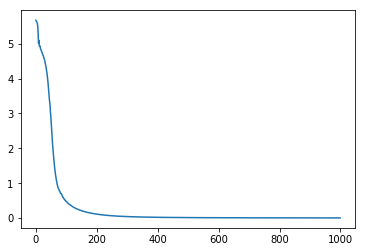

In [8]:
mp.plot(range(epochs), history.history['loss'])
mp.show()

## 创建解码模型

In [9]:
decoder_h_input = Input(shape=(units,))  # 解码器状态输入层h
decoder_c_input = Input(shape=(units,))  # 解码器状态输入层c
decoder_lstm_output, decoder_h, decoder_c = decoder_lstm(
    decoder_input, initial_state=[decoder_h_input, decoder_c_input])  # 解码器LSTM输出
decoder_output = decoder_softmax(decoder_lstm_output)  # 解码器输出
model_decoder = Model([decoder_input, decoder_h_input, decoder_c_input],
                      [decoder_output, decoder_h, decoder_c])  # 【解码器模型】

## 序列生成序列

In [10]:
def seq2seq(x_encoder_pred):
    h, c = model_encoder.predict(x_encoder_pred)
    id_pred = id_start
    seq = ''
    while id_pred != id_end:
        y_pred = to_categorical([[[id_pred]]], num_classes_output)
        output, h, c = model_decoder.predict([y_pred, h, c])
        id_pred = np.argmax(output[0])
        seq += id2chr_output[id_pred]
    return seq[:-1]

## 模型评估

In [12]:
for i in range(len(seqs)):
    seq = seq2seq(x_encoder[i: i + 1])
    print('原输入输出：\033[034m%s\033[0m' % seqs[i], '模型输出：\033[034m%s\033[0m' % seq)

原输入输出：汉皇重色思倾国，御宇多年求不得。 模型输出：御宇多年求不得
原输入输出：杨家有女初长成，养在深闺人未识。 模型输出：养在深闺人未识
原输入输出：天生丽质难自弃，一朝选在君王侧。 模型输出：一朝选在君王侧
原输入输出：回眸一笑百媚生，六宫粉黛无颜色。 模型输出：六宫粉黛无颜色
原输入输出：春寒赐浴华清池，温泉水滑洗凝脂。 模型输出：温泉水滑洗凝脂
原输入输出：侍儿扶起娇无力，始是新承恩泽时。 模型输出：始是新承恩泽时
原输入输出：云鬓花颜金步摇，芙蓉帐暖度春宵。 模型输出：芙蓉帐暖度春宵
原输入输出：春宵苦短日高起，从此君王不早朝。 模型输出：从此君王不早朝
原输入输出：承欢侍宴无闲暇，春从春游夜专夜。 模型输出：春从春游夜专夜
原输入输出：后宫佳丽三千人，三千宠爱在一身。 模型输出：三千宠爱在一身
原输入输出：金屋妆成娇侍夜，玉楼宴罢醉和春。 模型输出：玉楼宴罢醉和春
原输入输出：姊妹弟兄皆列土，可怜光彩生门户。 模型输出：可怜光彩生门户
原输入输出：遂令天下父母心，不重生男重生女。 模型输出：不重生男重生女
原输入输出：骊宫高处入青云，仙乐风飘处处闻。 模型输出：仙乐风飘处处闻
原输入输出：缓歌慢舞凝丝竹，尽日君王看不足。 模型输出：尽日君王看不足
原输入输出：渔阳鼙鼓动地来，惊破霓裳羽衣曲。 模型输出：惊破霓裳羽衣曲
原输入输出：九重城阙烟尘生，千乘万骑西南行。 模型输出：千乘万骑西南行
原输入输出：翠华摇摇行复止，西出都门百余里。 模型输出：西出都门百余里
原输入输出：六军不发无奈何，宛转蛾眉马前死。 模型输出：宛转蛾眉马前死
原输入输出：花钿委地无人收，翠翘金雀玉搔头。 模型输出：翠翘金雀玉搔头
原输入输出：君王掩面救不得，回看血泪相和流。 模型输出：回看血泪相和流
原输入输出：黄埃散漫风萧索，云栈萦纡登剑阁。 模型输出：云栈萦纡登剑阁
原输入输出：峨嵋山下少人行，旌旗无光日色薄。 模型输出：旌旗无光日色薄
原输入输出：蜀江水碧蜀山青，圣主朝朝暮暮情。 模型输出：圣主朝朝暮暮情
原输入输出：行宫见月伤心色，夜雨闻铃肠断声。 模型输出：夜雨闻铃肠断声
原输入输出：天旋地转回龙驭，到此踌躇不能去。 模型输出：到此踌躇不能去
原输入输出：马嵬坡下泥土中，不见玉颜空死处。 模型输出：不见玉颜空死处
原输入输出：君臣相顾尽沾衣，东望都门信马归。 模型输出：

In [ ]:
for _ in range(5):
    chrs = input('输入：').strip()  # 输入7个字
    x_encoder_pred = to_categorical([[chr2id_input[c] for c in chrs]], num_classes_input)
    seq = seq2seq(x_encoder_pred)
    print('输出：%s\n' % seq)